#### Text Mining and Sentiment Analysis

#### Sofia Introzzi, 967164

### Explain your opinion (P7) 


### Import libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import sklearn 
import json
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.stem import LancasterStemmer
import string
import re

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

In [5]:
from sklearn.metrics.pairwise import cosine_similarity

In [6]:
import collections
from collections import Counter

In [7]:
from bornrule import BornClassifier

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [10]:
from sklearn.metrics import classification_report

In [11]:
from sklearn.metrics import confusion_matrix

In [12]:
import spacy
nlp = spacy.load('en_core_web_lg')

In [13]:
import networkx as nx
from spacy.displacy import render

In [14]:
from collections import defaultdict
import time

In [15]:
from nltk.corpus import wordnet as wn
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sofiaintrozzi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Data

In [16]:
law = pd.read_csv('/Users/sofiaintrozzi/Text Mining and Sentiment Analysis/Project/SigmaLaw-ABSA.csv')

In [17]:
law = law[~(law['Overall Sentiment']==0)]
law.head(5)

,Sentence,Party,Sentiment,Overall Sentiment
4,"In 2008, federal officials received a tip from...","[[lee],[federal officials]]","[[-1],[1]]",-1
5,"In 2008, federal officials received a tip from...","[[],[federal officials]]","[[],[1]]",1
6,Lee had sold the informant ecstasy and marijuana.,"[[lee],[]]","[[-1],[]]",-1
7,"After obtaining a warrant, the officials searc...","[[lee],[officials,they]]","[[-1],[1,1]]",-1
9,"they found drugs, cash, and a loaded rifle.","[[],[they]]","[[],[1]]",1


In [18]:
len(law)

1620

<Axes: >

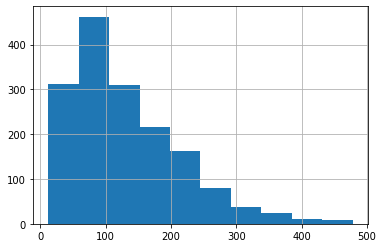

In [19]:
law['textLen']= law['Sentence'].str.len()
law['textLen'].hist()

### Sentiment Analysis classification of documents

#### Preprocessing

In [20]:
def process_sentence(sentence):
    tokens = [token.text.lower() for token in nlp(sentence)]
    tokens = [tk for tk in tokens if tk not in string.punctuation]
    tokens = [re.sub("n't", "not", tk) for tk in tokens]
    stop_words = stopwords.words("english")
    if "n't" in stop_words:
        stop_words.remove("n't")
    if "not" in stop_words:
        stop_words.remove("not")        
    tokens = [tk for tk in tokens if tk not in stop_words]
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(tk) for tk in tokens]
    return tokens

In [21]:
text = law['Sentence']

In [22]:
preprop = [process_sentence(sentence) for sentence in text]

In [23]:
sentiment = list(law['Overall Sentiment'])

In [24]:
documents = pd.DataFrame({'Sentence': preprop, 'Sentiment': sentiment})

In [25]:
documents

,Sentence,Sentiment
0,"[2008, feder, offici, receiv, tip, confidenti,...",-1
1,"[2008, feder, offici, receiv, tip, confidenti,...",1
2,"[lee, sold, inform, ecstasi, marijuana]",-1
3,"[obtain, warrant, offici, search, lee, ’s, hou...",-1
4,"[found, drug, cash, load, rifl]",1
...,...,...
1615,"[carri, elebi, linda, jacob, stestifi, heard, ...",-1
1616,"[final, govern, play, videotap, petition, yarb...",-1
1617,"[none, defend, rebut, prosecut, wit, ’, claim,...",-1
1618,"[govern, not, contest, petition, ’, claim, wit...",-1


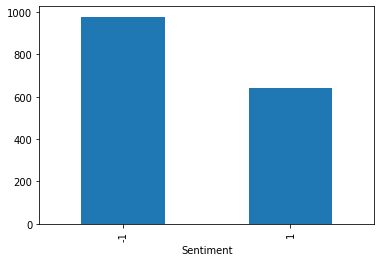

In [26]:
fig = documents['Sentiment'].value_counts().plot(kind='bar')
labelFig = fig.get_figure()

### TF-IDF term frequency Inverse document frequency 

In [27]:
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(text).toarray()
np.unique(X_tfidf)

for key, value in collections.Counter(X_tfidf.flatten()).items():
    if value==1:
        pass
    else:
        print(f"{key}: {value}")

0.0: 5791750
0.26560015310260604: 2
0.3917809694194223: 2
0.3747014582462132: 2
0.31320924100840813: 3
0.3260730614157083: 2
0.2822148840415029: 2
0.47196780219999046: 3
0.23819656826578217: 2
0.256230307954803: 2
0.4394269899051448: 2
0.3295286190384203: 2
0.2204466490563325: 2
0.21137916550464497: 2
0.13692903604212808: 2
0.465133115613246: 2
0.4160961524157284: 2
0.27278374774358566: 2
0.26829072595575937: 2
0.2541588143657685: 3
0.2121960489212297: 2
0.18982514155659258: 2
0.19581473866134982: 2
0.3004911523734306: 2
0.30997262000992115: 2
0.26892692347245784: 2
0.24674671465223239: 2
0.38308551861617124: 2
0.4331724035584672: 2
0.15106017254493584: 2
0.15794574463980823: 2
0.1344699316466156: 2
0.15425620079587585: 2
0.11787969074829542: 2
0.13035675447326503: 2
0.16765041344325604: 2
0.48885055280169565: 2
0.4377150514352443: 2
0.3747336451876506: 2
0.12173341221270477: 2
0.15388751059399003: 2
0.21571915924669616: 2
0.5864897447569131: 2
0.21950041245894636: 3
0.1899766977996036

### train and test split

In [28]:
labels = documents['Sentiment'].tolist()
category_list = documents['Sentiment'].unique()

In [29]:
X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test = train_test_split(X_tfidf, labels, train_size=0.75, stratify=labels, random_state=1)

### Born Classifier

In [30]:
bc = BornClassifier()
bc.fit(X_tfidf_train, y_tfidf_train)
bc_pred = bc.predict(X_tfidf_test)

In [31]:
print(classification_report(y_tfidf_test, bc_pred, zero_division=0))

              precision    recall  f1-score   support

          -1       0.76      0.79      0.77       244
           1       0.66      0.62      0.64       161

    accuracy                           0.72       405
   macro avg       0.71      0.70      0.71       405
weighted avg       0.72      0.72      0.72       405



In [32]:
confusion = confusion_matrix(y_tfidf_test, bc_pred)

In [33]:
confusion_df = pd.DataFrame(confusion, index=category_list, columns=category_list)

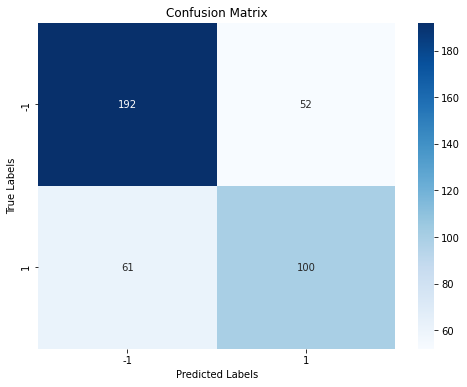

In [34]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Relevant features derivation

## Spacy parcing, syntax dependecies

### helpers

In [35]:
def spacy_sentences(nlp, text):
    sentences = []
    for sent in nlp(text).sents:
        sentences.append(sent)
    return sentences

In [36]:
token_map = lambda span: dict([(x.idx, x) for x in span])

In [37]:
def explore(token, children=None, level=0, order=None):
    if children is None:
        children = []
    if order is None:
        order = token.idx
    for child in token.children:
        children.append((child, level, child.idx < order))
        explore(child, children=children, level=level+1, order=order)
    return children

In [38]:
def search_adjectives(nlp_text, nouns=None):
    nouns_map = dict([(x, []) for x in nlp_text if x.pos_ in ['NOUN', 'PROPN']])
    if nouns is None:
        nouns = nouns_map.keys()
    else:
        pass
    for noun in nouns:
        subtree = explore(noun)
        subnouns = [(x, l) for x, l, _ in subtree if x.pos_ in ['NOUN', 'PROPN']]
        for token, level, left in subtree:
            if token.pos_ == 'ADJ' and len([(n, l) for n, l in subnouns if l < level]) == 0:
                try:
                    nouns_map[noun].append(token)
                except KeyError:
                    pass
    return nouns_map

In [39]:
def verb_adjectives(text, adjective_map, be_only=True):
    if be_only:
        verbs = [x for x in text if x.lemma_ == 'be']
    else:
        verbs = [x for x in text if x.pos_ in {'AUX', 'VERB'}]
    for verb in verbs:
        subtokens = explore(verb)
        subject = [(x) for x, level, left in subtokens if left and x.dep_ == 'nsubj']
        if len(subject) > 0:
            subj = subject[0]
            for candidate, level, left in subtokens:
                if not left:
                    if candidate.pos_ == 'ADJ' and level == 0:
                        try:
                            adjective_map[subj].append(candidate)
                        except KeyError:
                            pass
                    elif candidate.dep_ in ['dobj', 'attr', 'conj']:
                        adj = search_adjectives(text, nouns=[candidate])
                        try:
                            adjective_map[subj] += adj[candidate]
                        except KeyError:
                            pass
                    else:
                        pass

### visual representation of a syntactic dependecy

In [40]:
sentence_eg = spacy_sentences(nlp, (law['Sentence'].tolist()[507]))

In [41]:
sentence_eg

[We reject Jackson's alternative claim]

In [42]:
render(sentence_eg)

In [43]:
adj_map = search_adjectives(sentence_eg[0])
adj_map

{Jackson: [], claim: [alternative]}

#### tokenization, lemma and pos

In [44]:
def tokenize(text):
    doc = nlp(text)
    tokens = []
    for sentence in doc.sents:
        tokens.append([(t.lemma_, t.pos_) for t in sentence])
    return tokens

#### moving window of three tokens

In [45]:
def shift_ngrams(text, window=3):
    grams = []
    for sent in tokenize(text):
        for i, (token, pos) in enumerate(sent):
            if pos == 'NOUN':
                grams.append(token)
                for token_j, pos_j in sent[max([i-window, 0]):i+window+1]:
                    if pos_j in ['NOUN', 'ADJ', 'VERB', 'ADV'] and token_j != token:
                            grams.append((token_j, token))
    return grams

#### unigrams, bigrams dictionaries 

In [46]:
unigram = defaultdict(lambda: 0) 
bigram = defaultdict(lambda: defaultdict(lambda: 0))

### unigrams and bigrams retrieval

In [47]:
headers = law['Sentence'].values

In [48]:
for i, text in tqdm(enumerate(headers)):
    for token in shift_ngrams(text):
        if isinstance(token, tuple):
            for x in token:
                unigram[x] += 1
            bigram[token[1]][token[0]] += 1
        else:
            unigram[token] += 1

U = dict(unigram)
B = {}
for x, y in bigram.items():
    data = dict(y)
    B[x] = data

## Candidate aspects detenction

## Noun - Adjective pairs

In [49]:
documents = law['Sentence'].tolist()
sentiment = law['Overall Sentiment'].tolist()

In [50]:
stats_data = []
runs = list(enumerate(documents))

for i, doc in tqdm(runs):
    sent = sentiment[i]
    sample = spacy_sentences(nlp, doc)
    for sent in sample:
        nm = search_adjectives(sent)
        verb_adjectives(sent, adjective_map=nm)
        for n, adjs in nm.items():
            for a in adjs:
                    stats_data.append({
                        'doc': i,
                        'adj': a.lemma_.lower(),
                        'noun': n.lemma_.lower()
                    })
pair_df = pd.DataFrame(stats_data)

In [51]:
len(pair_df)

1830

In [52]:
pair_df.head()

,doc,adj,noun
0,0,federal,official
1,0,confidential,informant
2,1,federal,official
3,1,confidential,informant
4,3,loaded,rifle


## Frequences 

In [53]:
doc = pair_df.groupby(['doc', 'adj', 'noun']).first().reset_index()[['doc', 'adj', 'noun']]

In [54]:
doc.head()

,doc,adj,noun
0,0,confidential,informant
1,0,federal,official
2,1,confidential,informant
3,1,federal,official
4,3,loaded,rifle


### adjectives - nouns

In [55]:
threshold = 8

In [56]:
adj_noun = doc.groupby(['adj', 'noun']).count()
adj_noun = adj_noun[adj_noun.doc > threshold]

### adjectives

In [57]:
adj = doc.groupby('adj').count()['doc']
adj = pd.DataFrame(adj[adj > threshold])

### nouns

In [58]:
noun = doc.groupby('noun').count()['doc']
noun = pd.DataFrame(noun[noun > threshold])

## probabilities

### adjective - noun

In [59]:
adj_noun_sum = adj_noun.sum()['doc']
adj_noun['p'] = adj_noun.doc / adj_noun_sum

In [60]:
adj_noun.sort_values('p', ascending=False)

,,doc,p
adj,noun,,
summary,judgment,19,0.162393
first,degree,13,0.111111
full,value,13,0.111111
guilty,plea,13,0.111111
absolute,immunity,12,0.102564
ineffective,assistance,10,0.085470
reasonable,person,10,0.085470
adequate,warning,9,0.076923
grand,jury,9,0.076923


### adjectives 

In [61]:
adj_sum = adj.sum()['doc']
adj['p'] = adj.doc / adj_sum

In [62]:
adj.sort_values('p', ascending=False).head()

,doc,p
adj,,
other,50,0.063613
federal,48,0.061069
prior,29,0.036896
first,29,0.036896
new,26,0.033079


### nouns 

In [63]:
noun_sum = noun.sum()['doc']
noun['p'] = noun.doc / noun_sum

In [64]:
noun.sort_values('p', ascending=False).head()

,doc,p
noun,,
evidence,42,0.054475
statement,25,0.032425
right,25,0.032425
testimony,23,0.029831
value,23,0.029831


## PMI Pointwise Mutual Information 

In [65]:
pmi = []
for (a, n), row in adj_noun.iterrows():
    pmi.append({'adj': a, 'noun': n, 'pmi': np.log(row.p / (adj.loc[a].p * noun.loc[n].p))})
pmi_an = pd.DataFrame(pmi)
pmi_an.set_index(['adj', 'noun'], inplace=True)

In [66]:
pmi_an

,,pmi
adj,noun,
absolute,immunity,5.307278
adequate,warning,5.579212
first,degree,4.916911
full,value,5.342869
grand,jury,5.987522
guilty,plea,5.333595
ineffective,assistance,5.844421
prior,conviction,4.337878
reasonable,person,4.719491


## similarity measure 

## uni-bigrams 

In [67]:
V = list(U.keys())
k = pmi_an.index.get_level_values(1).tolist()

In [68]:
# PMI 

In [69]:
def pab(w1, w2, idx, uidx):
    n = sum(uidx.values())
    try:
        p = idx[w1][w2]
        z = sum(idx[w1].values())
        p_ab = p / z
        p_w1 = uidx[w1] / n
        p_w2 = uidx[w2] / n
        p_c = p_w1 * p_w2
        pmi = p_ab * np.log(p_ab / p_c)
    except KeyError:
        return 0
    return pmi

In [70]:
m = np.zeros((len(k), len(V)))
for w in k:
    i = k.index(w)
    for w_con, _ in B[w].items():
        try:
            j = V.index(w_con)
            m[i,j] = pab(w, w_con, B, U)
        except IndexError:
            pass

In [71]:
m.shape

(10, 2143)

In [72]:
sigma = cosine_similarity(m, m)

## Clustering

In [73]:
kmeans = KMeans(n_clusters=5)
clusters = kmeans.fit_predict(m)

In [74]:
c_si = set(clusters)

In [75]:
vectors = {}
for c in c_si:
    bag = []
    for i, cluster in enumerate(clusters):
        if cluster == c:
            bag.append(k[i])
    vectors[c] = bag

In [76]:
vectors

{0: ['assistance'],
 1: ['warning', 'value', 'jury', 'plea', 'conviction', 'person'],
 2: ['degree'],
 3: ['judgment'],
 4: ['immunity']}

In [77]:
m_0 = np.array([m[k.index(w)] for w in vectors[0]])

In [78]:
m_1 = np.array([m[k.index(w)] for w in vectors[1]])

In [79]:
m_2 = np.array([m[k.index(w)] for w in vectors[2]])

In [80]:
m_3 = np.array([[k.index(w)] for w in vectors[3]])

In [81]:
m_4 = np.array([m[k.index(w)] for w in vectors[4]])

In [82]:
print(m_0.shape)
print(m_1.shape)
print(m_2.shape)
print(m_3.shape)
print(m_4.shape)

(1, 2143)
(6, 2143)
(1, 2143)
(1, 1)
(1, 2143)


In [83]:
sim_c = cosine_similarity(kmeans.cluster_centers_[1].reshape(1, -1), m_1)

# PMI for Sentiment Analysis 

In [84]:
adjs, nouns = doc['adj'].values, doc['noun'].values

In [85]:
doc['sentiment'] = [sentiment[x] for x in doc['doc'].values]

In [86]:
doc['pmi_an'] = [pmi_an.loc[ (adjs[i], nouns[i]) ].pmi if (adjs[i], nouns[i] ) in pmi_an.index else np.nan
                 for i in range(doc.shape[0])]

In [87]:
no_doc = doc[~doc['pmi_an'].isna()]

In [88]:
no_doc

,doc,adj,noun,sentiment,pmi_an
6,5,grand,jury,-1,5.987522
7,6,grand,jury,-1,5.987522
14,12,ineffective,assistance,-1,5.844421
15,13,ineffective,assistance,-1,5.844421
16,14,ineffective,assistance,-1,5.844421
...,...,...,...,...,...
1676,1479,grand,jury,1,5.987522
1720,1534,summary,judgment,1,5.507949
1721,1535,summary,judgment,1,5.507949
1753,1564,grand,jury,1,5.987522


## Classification

In [89]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(no_doc[['pmi_an']].values)

In [90]:
features = list(pmi_an.index.values)

In [91]:
X = np.zeros((no_doc.shape[0], len(features)))
adjs, nouns = no_doc['adj'].values, no_doc['noun'].values

In [92]:
for i in range(no_doc.shape[0]):
    a = adjs[i]
    n = nouns[i]
    idx = features.index((a, n))
    X[i, idx] = scaled[i, 0]     

# Born classifier

In [99]:
y = no_doc['sentiment'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [100]:
bc = BornClassifier()
bc.fit(X_train, y_train)
bc_pred = bc.predict(X_test)

In [101]:
print(classification_report(y_test, bc_pred, zero_division=0))

              precision    recall  f1-score   support

          -1       0.83      0.76      0.79        25
           1       0.54      0.64      0.58        11

    accuracy                           0.72        36
   macro avg       0.68      0.70      0.69        36
weighted avg       0.74      0.72      0.73        36



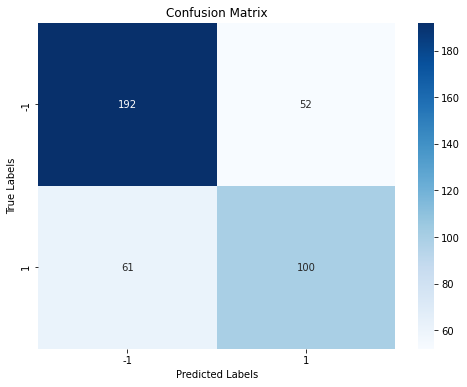

In [102]:
confusion_df = pd.DataFrame(confusion, index=category_list, columns=category_list)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Explanation

In [103]:
ex = pd.DataFrame(bc.explain(), index=features)

In [111]:
ex

,0,1
"(absolute, immunity)",0.021987,0.016453
"(adequate, warning)",0.036871,0.059605
"(first, degree)",0.377964,0.000000
"(full, value)",0.004475,0.005115
"(grand, jury)",0.000021,0.000021
"(guilty, plea)",0.002064,0.001892
"(ineffective, assistance)",0.011180,0.009037
"(prior, conviction)",0.000000,0.000000
"(reasonable, person)",0.000021,0.000021
"(summary, judgment)",0.038576,0.059161


In [105]:
expl = pd.DataFrame(bc.explain(X[0].reshape(1, -1)), index=features)

In [106]:
expl

,0,1
"(absolute, immunity)",0.000000,0.000000
"(adequate, warning)",0.000000,0.000000
"(first, degree)",0.000000,0.000000
"(full, value)",0.000000,0.000000
"(grand, jury)",0.000021,0.000021
"(guilty, plea)",0.000000,0.000000
"(ineffective, assistance)",0.000000,0.000000
"(prior, conviction)",0.000000,0.000000
"(reasonable, person)",0.000000,0.000000
"(summary, judgment)",0.000000,0.000000
